In [163]:
import matplotlib.pyplot as plt
import numpy as np
import math


def f(x):
    return 3*x**2 - 4*x + 5

In [164]:
f(3.0)

20.0

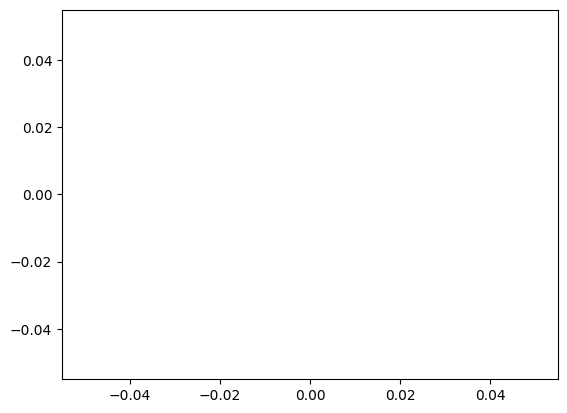

In [165]:
x5 = np.arange(-5, -5, 0.25)
y5 = f(x5)
plt.plot(x5, y5)

In [166]:
h = 0.00001
x = 2 / 3
( f(x + h) - f(x) )/ h

3.0000002482211127e-05

In [167]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [168]:
d1 = a*b + c
b += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2 - d1) / h)

d1: 4.0
d2: 4.00002
slope: 2.0000000000131024


In [169]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self.__mul__(other)

    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data ** other.data, (self, ), f"**{other.data}")
        def _backward():
            self.grad += other.data * self.data ** (other.data - 1) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * (other**-1)

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def tanh(self):
        n = self.data
        t = (math.exp(n) - math.exp(-n)) / (math.exp(n) + math.exp(-n))
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1.0
        topo =[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self) # build topological order

        for node in reversed(topo):
            node._backward()

In [170]:
a = Value(2.0)
b = Value(-3.0)
a / b

Value(data=-0.6666666666666666)

In [171]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node (name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [172]:
def lol():

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L

    print((L1.data - L2.data) / h)
lol()

6.000000000021544


In [173]:
a = Value(2.0 + h, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(2.0, label='f')
L = d * f; L.label = 'L'

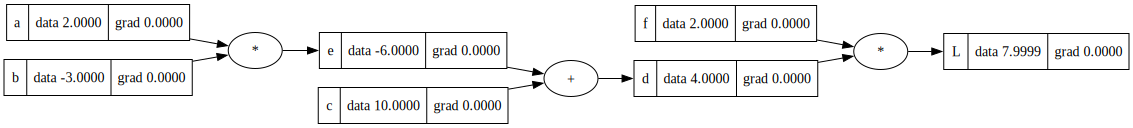

In [174]:
draw_dot(L)

In [175]:
L.grad = 1.0
d.grad = L.grad * f.data
f.grad = L.grad * d.data
e.grad = d.grad * 1
c.grad = d.grad * 1
b.grad = e.grad * a.data
a.grad = e.grad * b.data

In [176]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'


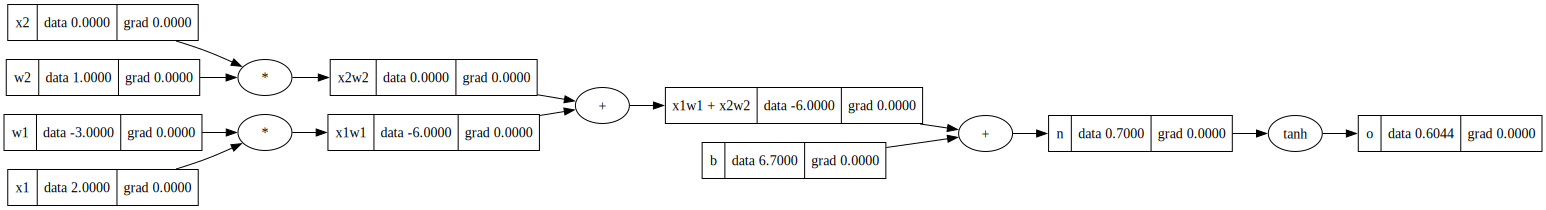

In [177]:
draw_dot(o)

In [178]:
o.backward()

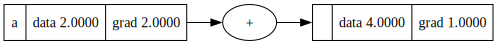

In [179]:
a = Value(2.0, label='a')
b = a + a

b.backward()
draw_dot(b)

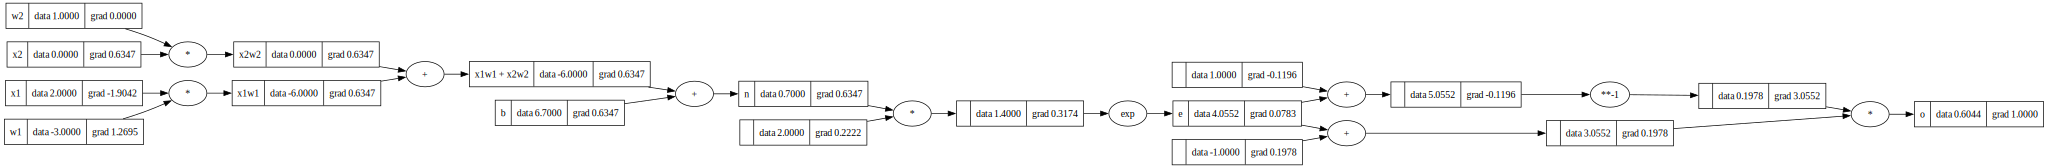

In [180]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2.0 * n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [181]:
import torch

In [182]:
x1 = torch.tensor([2.0], requires_grad=True)
x2 = torch.tensor([0.0], requires_grad=True)
w1 = torch.tensor([-3.0], requires_grad=True)
w2 = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([6.7], requires_grad=True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

0.6043676733970642
-1.9042192697525024
0.6347397565841675
1.269479513168335
0.0


In [183]:
import random

In [184]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        self.layers = [Layer(nin, nouts[0])]
        self.layers += [Layer(nouts[i], nouts[i+1]) for i in range(len(nouts)-1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [185]:

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7299973818078337)

In [186]:
n.parameters()

[Value(data=-0.8498094815696999),
 Value(data=-0.775754624972059),
 Value(data=-0.08360382989155002),
 Value(data=0.44217579913573),
 Value(data=0.14763054266734055),
 Value(data=0.875648980679889),
 Value(data=0.4636619093233685),
 Value(data=-0.6694851335964389),
 Value(data=-0.2879518345656136),
 Value(data=0.1872879703176571),
 Value(data=-0.7766531664987246),
 Value(data=0.4504747167874472),
 Value(data=0.24527350111555113),
 Value(data=-0.8096291058460976),
 Value(data=-0.21458923172384115),
 Value(data=-0.2687051447895876),
 Value(data=-0.5253241176749459),
 Value(data=0.19841653353499789),
 Value(data=0.4447657718326983),
 Value(data=-0.5545232535147604),
 Value(data=-0.5476799722526873),
 Value(data=0.9779079318845716),
 Value(data=-0.6057757566706903),
 Value(data=0.8110499737422938),
 Value(data=0.020734983644251193),
 Value(data=-0.8889184465000031),
 Value(data=0.4075406910386774),
 Value(data=0.2071117550044541),
 Value(data=-0.7090390224024254),
 Value(data=0.02339483196

In [187]:
xs = [
    [2.0, 3.0, -1.0],
    [1.0, -2.0, 0.0],
    [-1.0, 1.0, 2.0],
    [0.0, 2.0, -2.0]
]
ys = [1.0, -1.0, 1.0, -1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7299973818078337),
 Value(data=-0.5549709692184621),
 Value(data=-0.28433831442507773),
 Value(data=0.5154100436491982)]

In [203]:
for k in range(10):
    ypred = [n(x) for x in xs]
    loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

0 0.010587052243018442
1 0.010427635966778266
2 0.010274096411186878
3 0.010126093949152403
4 0.0099833152513191
5 0.009845470760212988
6 0.009712292451882185
7 0.009583531847411036
8 0.009458958242228812
9 0.00933835712576486


In [199]:
loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
loss

Value(data=0.024255501950199074)

In [190]:
loss.backward()

In [191]:
n.layers[0].neurons[0].w[0].grad

-7.199186144251154

In [192]:
n.layers[0].neurons[0].w[0].data

-0.7519577095970786

In [193]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [194]:
n.layers[0].neurons[0].w[0].data

-0.6799658481545671

In [195]:
ypred = [n(x) for x in xs]
loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
loss

Value(data=0.08080415633109196)

In [196]:
ypred = [n(x) for x in xs]
loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
loss

Value(data=0.08080415633109196)

In [197]:
loss.backward()
for p in n.parameters():
    p.data += -0.01 * p.grad
ypred = [n(x) for x in xs]

loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
print(ypred)
print(loss)

[Value(data=0.7861524070021242), Value(data=-0.9423442945211771), Value(data=0.9493709836723301), Value(data=-0.9815104483237437)]
Value(data=0.05196013422074233)
